# Ireland Met Eireann West Coast Historical Wind Data Analysis <br/> Guillermo F. Martin Gonzalez

# Introduction
This notebooks contains all the analysis carried as part of the project for the 2024 **Programming for Data Analytics (PFDA)** course from the Atlantic Technical University. The project was set up quite open both in terms of the data to be used and the questions to be asked. I have followed the suggestion of downloading the historical wind data from the Met Eireann website (https://www.met.ie/climate/available-data/historical-data). I had never used wind or weather data in the past (I come from a fisheries data background), and found weather data to be quite interesting as weather patterns can be quite 

However, I have taken the assessment project a step further by downloading the data from three different weather stations in the West Coast of Ireland. 

# Data 
Three historical weather data `.csv` files were downloaded from the MetEireann website (above) belonging to the stations:

- hly275
- hly2275
- hly2375

The format of these `.csv` files was slightly different in the number of preliminary rows which described the column headers and the units of each column. In each of these files, we manually deleted this columns, and left the header as the first row. This was done to facilitate the loading of the data into Python. The data contained in this `.csv` files is decribed in the `KeyHourly.txt` file, but as a summary: 

- rain:Precipitation Amount (mm)
- temp: Air Temperature (°C)
- wetb: Wet Bulb Air Temperature (°C)
- dewpt: Dew Point Air Temperature (°C)		                 
- vappr: Vapour Pressure (hpa)
- rhum: Relative Humidity (%)
- msl: Mean Sea Level Pressure (hPa)
- wdsp: Mean Hourly Wind Speed (kt)
- wddir: Predominant Hourly wind Direction (deg)
- ww: Synop Code Present Weather - decode in `.txt`
- w: Synop Code Past Weather - decode `.txt`
- sun: Sunshine duration (hours)
- vis: Visibility (m)
- clht: Cloud Ceiling Height - if none value is 999 (100s feet)
- clamt: Cloud Amount (okta)


Additionally, we also downloaded the Station details from this website which contain useful information such as the location of the station or the opening year. 

In [15]:
# Loading libraries
import pandas as pd
import numpy as np 
import os, json 
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import folium as fo
#import plotly.express as px
from windrose import WindroseAxes
import io
import base64

In [16]:
# Loading all .csv files in the data folder
path_to_csv = './data'
csv_files = ['hly2375.csv','hly275.csv','hly2275.csv']

#Station details file: 
stdetails = pd.read_csv(os.path.join(path_to_csv,'StationDetails.csv'))
#Error tokenizing data. C error: Expected 10 fields in line 212, saw 11
# There was a mistake in line 212 in the original .csv file. The name of the station was divided between
# the station name and the height column. I merged them together manually. No height for this station. 
stdetails['height(m)'] = stdetails['height(m)'].astype(float).fillna(0).astype(int)


# Initialize a list to store all data
data_list = []

for index, d in enumerate(csv_files):
    with open(os.path.join(path_to_csv, d)) as csv_file:
        tmp = pd.read_csv(csv_file)
        #tmp['Location'] = d.split('_')[0]
        tmp['StId'] = int(d.split('.')[0].replace('hly', ''))
        data_list.append(tmp) 

data = pd.concat(data_list, ignore_index=True)       

# Merging station details
data = data.merge(stdetails[['station name', 'name', 'latitude', 'longitude']], left_on='StId', right_on='station name', how='left')
data.drop(columns=['station name'], inplace=True)

#Columns of interest to numeric:
dcolumns = ["rain","temp","wetb","dewpt","vappr",'wdsp','rhum','wddir'] # Columns of interest  
#Making sure they all are numeric
data[dcolumns] = data[dcolumns].apply(pd.to_numeric, errors='coerce')

#Date column and season

C:\Users\Owner\AppData\Local\Temp\ipykernel_1520\478093043.py:18: DtypeWarning: Columns (12,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(csv_file)
C:\Users\Owner\AppData\Local\Temp\ipykernel_1520\478093043.py:18: DtypeWarning: Columns (2,4,6,7,8,9,10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(csv_file)
C:\Users\Owner\AppData\Local\Temp\ipykernel_1520\478093043.py:18: DtypeWarning: Columns (2,4,6,7,8,9,10,12,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(csv_file)


In [17]:
data['date']

0          16/09/1956 15:00
1          16/09/1956 16:00
2          16/09/1956 17:00
3          16/09/1956 18:00
4          16/09/1956 19:00
                 ...       
1493957    30/11/2024 20:00
1493958    30/11/2024 21:00
1493959    30/11/2024 22:00
1493960    30/11/2024 23:00
1493961    01/12/2024 00:00
Name: date, Length: 1493962, dtype: object

In [18]:
# Basically I add together the date column after converting it to a string to the reportTime column, and then convert all of it to datetime.
data['date'] = pd.to_datetime(data['date'],format='%d/%m/%Y %H:%M')

#Extracting season and month for analysis later https://stackoverflow.com/questions/69024042/seasonal-windrose-subplots 
data['month'] = pd.to_datetime(data['date']).dt.month
data["season"] = data["date"].dt.month%12 //3 +1

season_dict = {1: "winter", 2: "spring", 
               3: "summer", 4: "autumn"}
data["season"] = data["season"].map(season_dict)

# Analysis
## Brief Overview
The following map shows the location of the stations downloaded. If you click on the markers, you will be able to see a windrose plot of all the historical wind speeds and wind directions for each station. A windrose plot is a really nice chart to display the main wind patterns. Wind direction is displayed over 360 degrees using columns or charts. The wind speed or strength is represented by colours within the charts (also referenced in a layer). We have normed the plot, meaning the data is normalized, so the numbers within each plot are percentages, meaning the sum of the different wind direction charts equals to one.  

For instance, in Bellmullet, the most dominant wind direction was from the West (11.6% of the time), followed by S to SW directions (around 9% of the time each). The range of the different colours also indicate the percentage fo the time the wind was blowing at that given range. In the Westerly direction, winds above 21 knots were blowing only around 2% of the time. 

If we make a quick comparison across the three stations, it is clear that the most dominant wind direction in Belmullet and Mace Head is from the West, although S-SW winds are more prevalent in Belmullet. Valentia shows a much more distinctive pattern, with dominant winds clearly blowing from the South (around 14% of the time), and winds above 21 knots being less common than in the stations to the North.


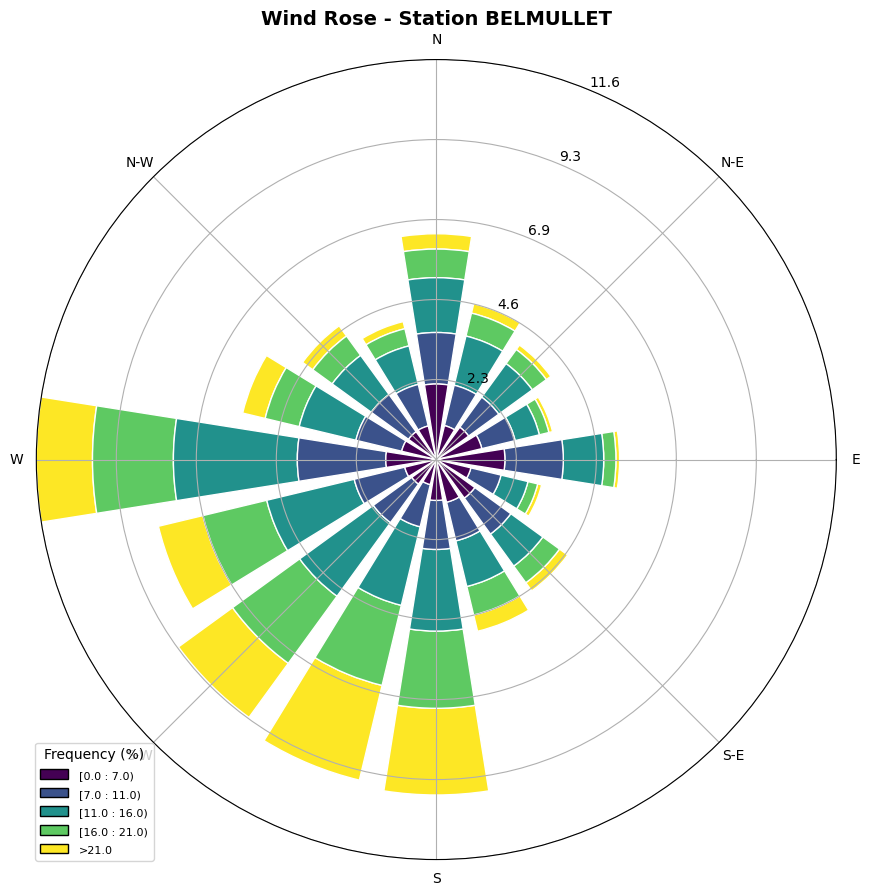
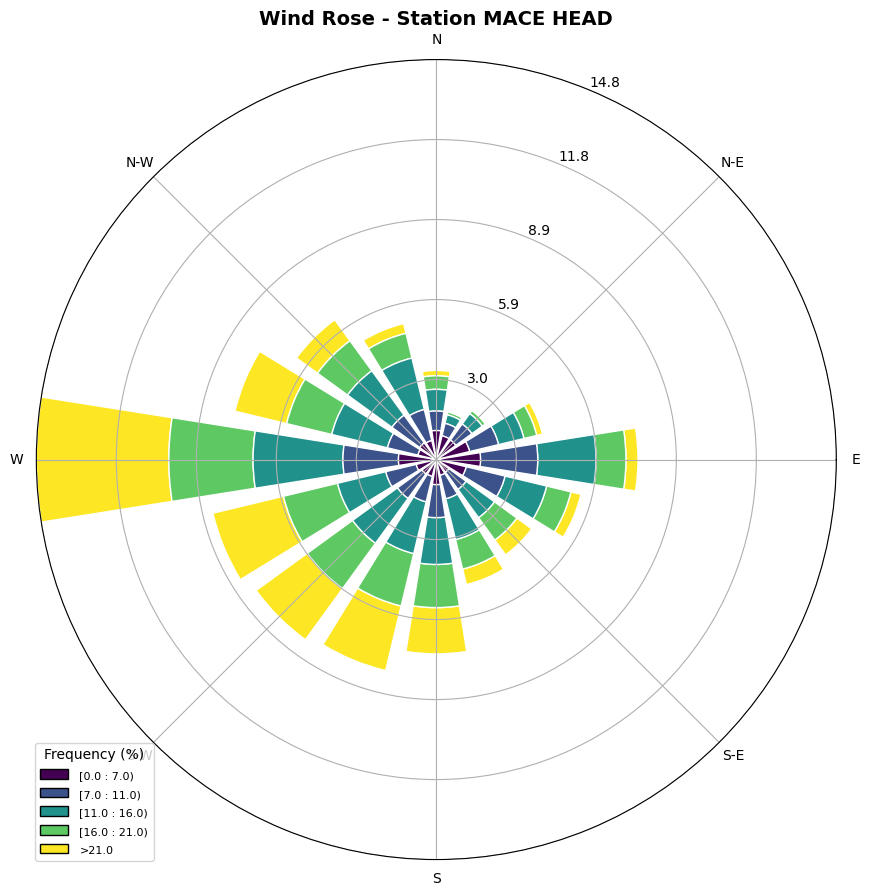
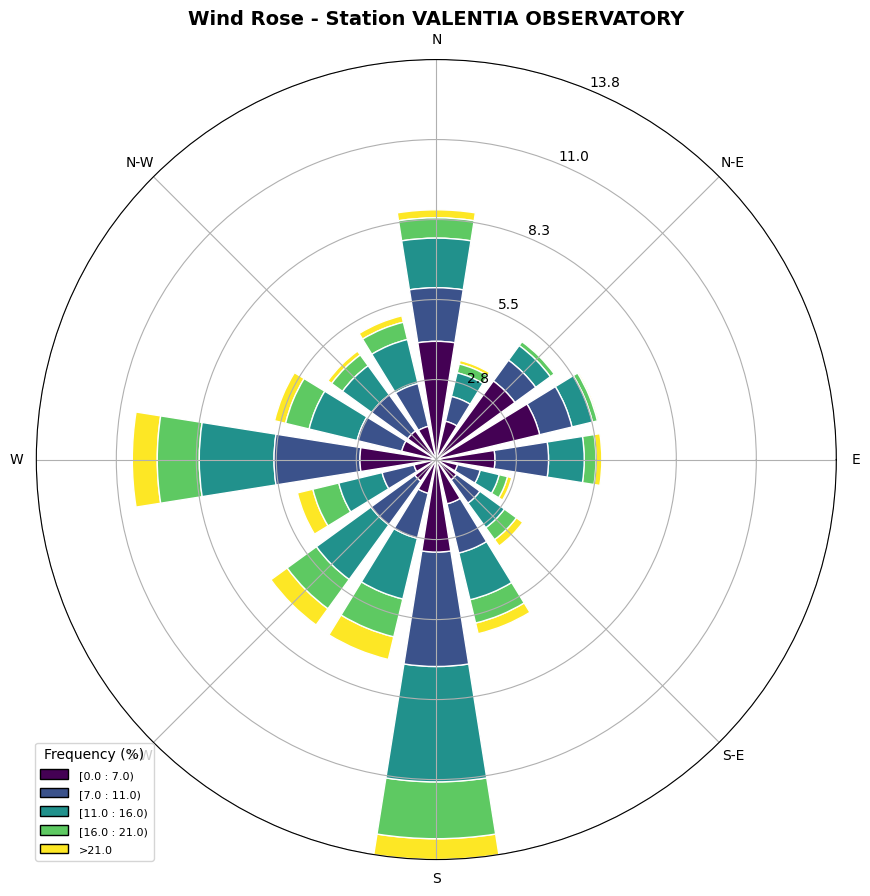

In [19]:
# Function to create a wind rose and return as a base64-encoded string

# Bins for the windrose colour breaks: 
bins= np.append(0, data['wdsp'].quantile([0.25, 0.5, 0.75, 0.9]).values) #Color breaks of windspeed based on speed quantiles

def make_windrose(ws, wd, station_id):
    fig = plt.figure(figsize=(10, 10))
    ax = WindroseAxes.from_ax(fig=fig)
    ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white',bins=bins)
    ax.set_legend(title="Frequency (%)", loc='lower left')
    plt.title(f"Wind Rose - Station {station_id}",fontsize=14, weight='bold')
    
    # Save the plot to a BytesIO buffer
    buf = io.BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight", transparent=True)
    buf.seek(0)
    base64_img = base64.b64encode(buf.read()).decode("utf-8")
    plt.close(fig)
    return f"data:image/png;base64,{base64_img}"

# Create a folium map
m = fo.Map(location=[data['latitude'].mean(), data['longitude'].mean()], zoom_start=6)

# Add wind roses to the map
for station_name in data['name'].unique():
    tmp = data[data['name'] == station_name]
    station_id = station_name
    lat = tmp['latitude'].iloc[0]
    lon = tmp['longitude'].iloc[0]

    # Generate wind rose as a base64-encoded image
    windrose_img = make_windrose(tmp['wdsp'], tmp['wddir'], station_id)
    
    # Add the image to the map as an HTML popup
    popup_html = f'<img src="{windrose_img}" style="width: 300px; height: 300px;">'
    popup = fo.Popup(popup_html, max_width=300)
    fo.Marker([lat, lon], popup=popup, tooltip=f"Station {station_id}").add_to(m)
    
    #To be directly displayed on the map withouth the need of a popup
    #html = f"""
    #<div style="width:200px; height:200px; background-color:white; border:1px solid black; border-radius:5px;">
    #    <img src="{windrose_img}" style="width:200px; height:200px; object-fit:contain;">
    #</div>
    #"""
    #icon = fo.DivIcon(html=html)
    #fo.Marker([lat, lon], icon=icon).add_to(m)
# Display the map
m

## Describing differences in wind patterns quantitatively
Altough the windroses help to visually understand the differences in wind direction and speed over the three different areas, we will explore deeper t


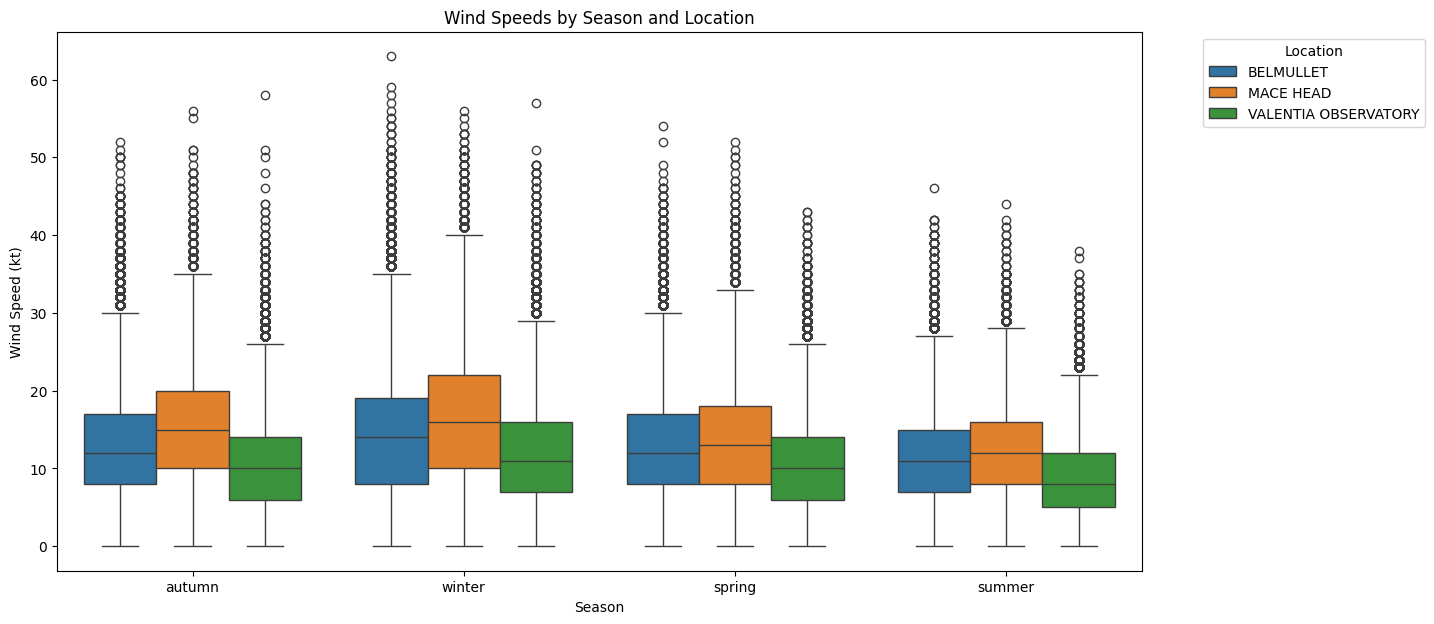

In [14]:
plt.figure(figsize=(14, 7))
sns.boxplot(x='season', y='wdsp', hue='name', data=data)
plt.xlabel('Season')
plt.ylabel('Wind Speed (kt)')
plt.title('Wind Speeds by Season and Location')
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()